Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [29]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [30]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

mounting image datasets from google drive

In [31]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)
root_path = 'gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration'

Mounted at /content/gdrive


In [32]:
path_to_train_directory = root_path+'/Train'
path_to_test_directory = root_path+'/Test'
len(list(pathlib.Path(path_to_train_directory).glob('**/**/*.jpg')))

2239

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [33]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)
len(list(data_dir_train.glob('*/*.jpg')))

2239

In [34]:
image_count_train = len(list(data_dir_train.glob('**/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('**/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [35]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [36]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = batch_size,
  image_size = (img_height,img_width),
  seed = 123,
  subset = "training",
  validation_split = 0.2
  
)

shape = tf.TensorShape([None,140,140,3])
print(shape)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
(None, 140, 140, 3)


In [37]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels = "inferred",
  label_mode = "categorical",
  color_mode = "rgb",
  batch_size = batch_size,
  image_size = (img_height,img_width),
  seed = 123,
  subset = "validation",
  validation_split = 0.2
  
)

print(train_ds)
print(val_ds)
print(tf.keras.utils.image_dataset_from_directory(data_dir_train, labels='inferred'))

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>
Found 2239 files belonging to 9 classes.
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [38]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

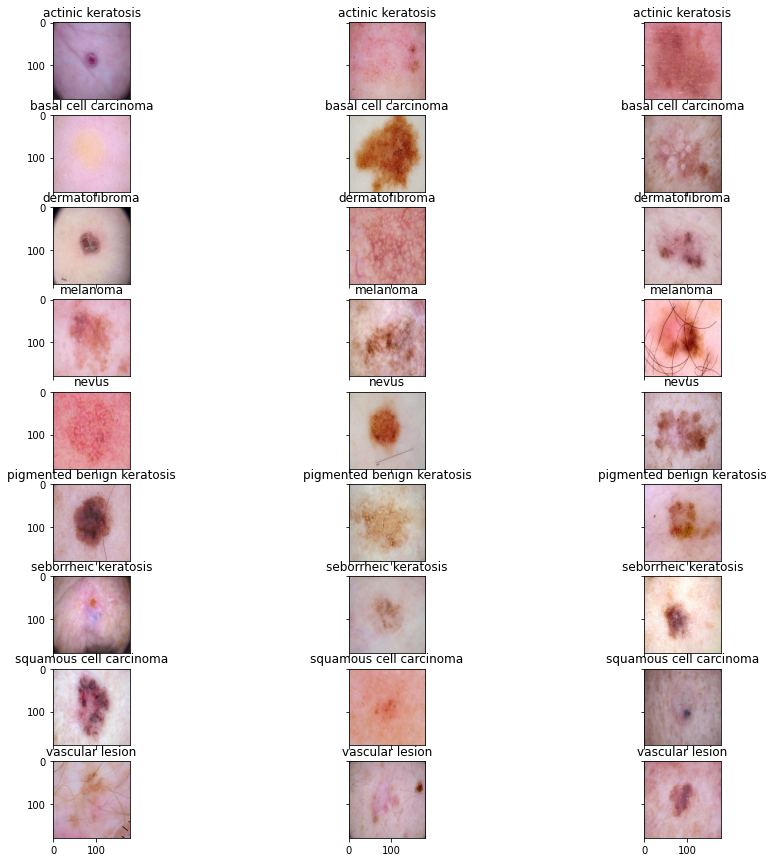

In [39]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
fig, ax = plt.subplots(9, 3, sharex=True, sharey=True, figsize=(15,15))
 
for images, labels in train_ds.take(1):
    for i in range(9):
        for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            ax[i][j].set_title(train_ds.class_names[i]) #[labels[i*3+j]])
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [41]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [42]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                   from_logits=False,
                   label_smoothing=0.0,
                    axis=-1,
                    #reduction=losses_utils.ReductionV2.AUTO,
                    name='categorical_crossentropy'
              ),
              #tf.keras.losses.categorical_crossentropy(from_logits=True),
              #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [23]:
! pip install pandas_ta==0.2.45b

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
! pip install numpy==1.20.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Train the model

In [44]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 149ms/step - loss: 2.0708 - accuracy: 0.1797 - val_loss: 2.0423 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0311 - accuracy: 0.1975 - val_loss: 2.0786 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0328 - accuracy: 0.2132 - val_loss: 2.0422 - val_accuracy: 0.1521
Epoch 4/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0062 - accuracy: 0.1981 - val_loss: 2.0245 - val_accuracy: 0.2103
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0244 - accuracy: 0.2065 - val_loss: 2.0340 - val_accuracy: 0.2081
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 2.1792 - accuracy: 0.2121 - val_loss: 2.0344 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 4s 79ms/step - loss: 2.0124 - accuracy: 0.2031 - val_loss: 2.0805 - val_accuracy: 0.2013
Epoch 8/20


### Visualizing training results

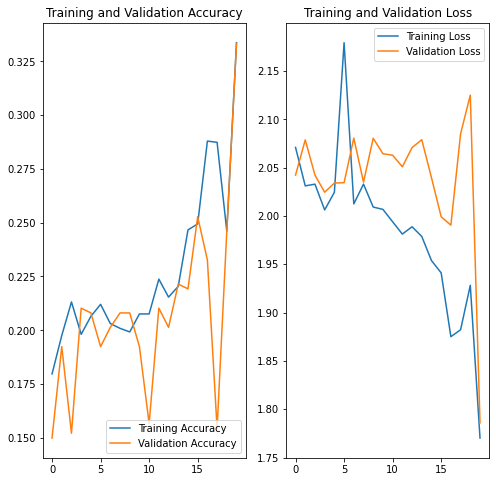

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here
The model appears to be overfitting because we can observe difference in loss functions in training & test around the 9th epoch

The accuracy is too low and it could too early to comment on the overfitting & underfitting 

In [46]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

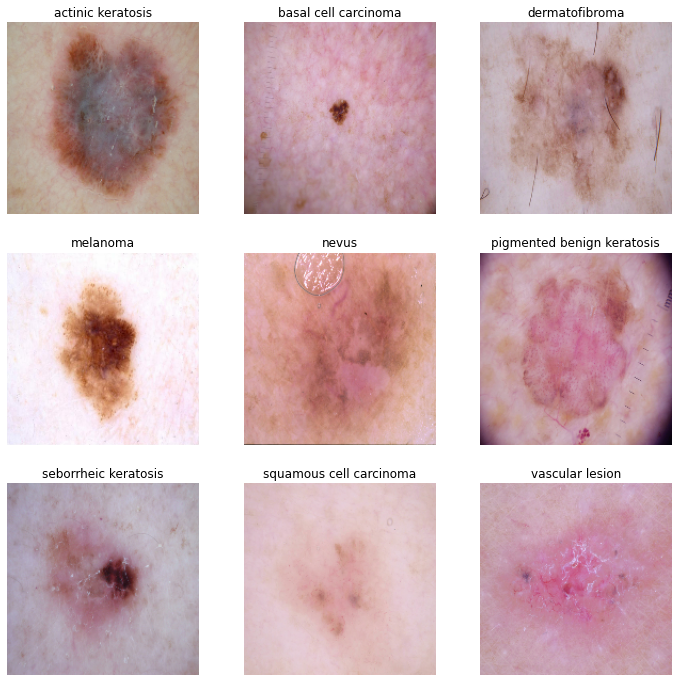

In [47]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [48]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [49]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                   from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    #reduction=losses_utils.ReductionV2.AUTO,
                    name='categorical_crossentropy'
              ),
              #tf.keras.losses.categorical_crossentropy(from_logits=True),
              #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [50]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 94ms/step - loss: 2.0290 - accuracy: 0.2137 - val_loss: 1.8685 - val_accuracy: 0.3177
Epoch 2/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9007 - accuracy: 0.2997 - val_loss: 1.7525 - val_accuracy: 0.3602
Epoch 3/20
56/56 [==============================] - 5s 88ms/step - loss: 2.0260 - accuracy: 0.2137 - val_loss: 1.9381 - val_accuracy: 0.2864
Epoch 4/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9533 - accuracy: 0.2600 - val_loss: 1.9082 - val_accuracy: 0.3087
Epoch 5/20
56/56 [==============================] - 5s 90ms/step - loss: 1.8744 - accuracy: 0.2946 - val_loss: 1.8138 - val_accuracy: 0.3132
Epoch 6/20
56/56 [==============================] - 5s 94ms/step - loss: 1.7499 - accuracy: 0.3482 - val_loss: 1.6377 - val_accuracy: 0.4116
Epoch 7/20
56/56 [==============================] - 5s 89ms/step - loss: 1.6950 - accuracy: 0.3878 - val_loss: 1.6227 - val_accuracy: 0.4295
Epoch 8/20
56

### Visualizing the results

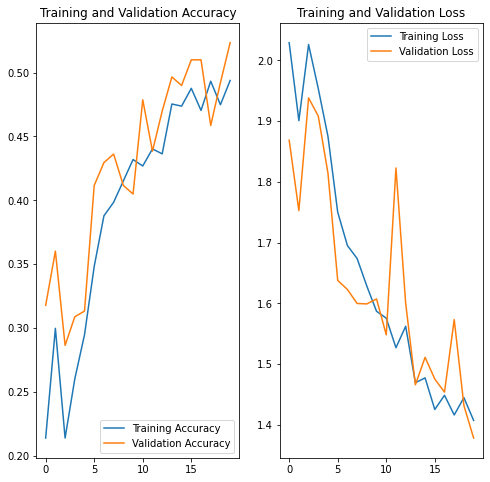

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

There is a definite improvement in accuracy over the prior model with accuracy trending above 50%  and we can definitely see the overfitting problem has solved due to data augmentation.. clearly visible through the loss function having a smooth declining trend compared to the last run where there was a lot of spikiness (spread across peaks & valleys in between) in trend



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [52]:
## Your code goes here.
path_list=[]
obj_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        obj_list.append(i)
dict_orig = dict(zip(path_list, obj_list))
orig_df = pd.DataFrame(list(dict_orig.items()),columns = ['Path','Label'])
orig_df

,Path,Label
0,gdrive/My Drive/Colab Notebooks/CNN_assignment...,actinic keratosis
1,gdrive/My Drive/Colab Notebooks/CNN_assignment...,actinic keratosis
2,gdrive/My Drive/Colab Notebooks/CNN_assignment...,actinic keratosis
3,gdrive/My Drive/Colab Notebooks/CNN_assignment...,actinic keratosis
4,gdrive/My Drive/Colab Notebooks/CNN_assignment...,actinic keratosis
...,...,...
2234,gdrive/My Drive/Colab Notebooks/CNN_assignment...,vascular lesion
2235,gdrive/My Drive/Colab Notebooks/CNN_assignment...,vascular lesion
2236,gdrive/My Drive/Colab Notebooks/CNN_assignment...,vascular lesion
2237,gdrive/My Drive/Colab Notebooks/CNN_assignment...,vascular lesion


<BarContainer object of 9 artists>

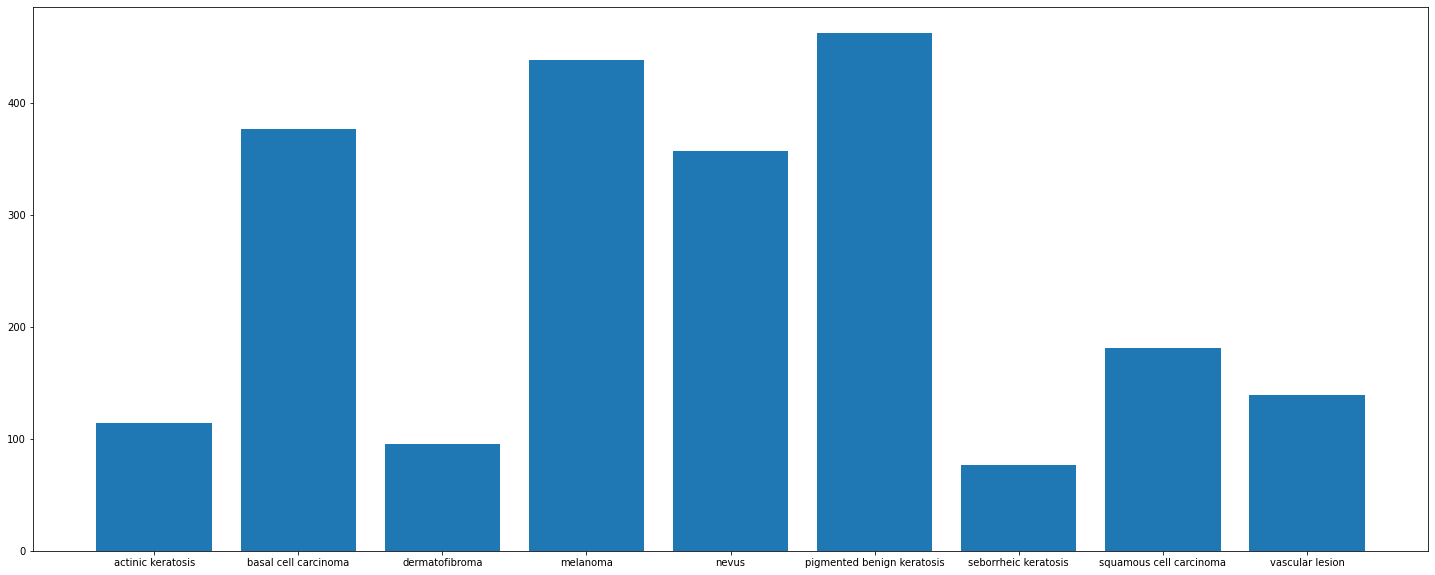

In [53]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
sebborrheic keratosis has least number of samples


#### - Which classes dominate the data in terms proportionate number of samples?
melanoma and pigmented benign keratosis have proprtionate number of classes

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [54]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
data_dir_train

PosixPath('gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [56]:
path_to_training_dataset=data_dir_train #'gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'  
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset,save_format='jpg') #+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DD434E550>: 100%|██████████| 500/500 [00:53<00:00,  9.27 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DD4E67A10>: 100%|██████████| 500/500 [00:59<00:00,  8.39 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9DD5F5C850>: 100%|██████████| 500/500 [00:48<00:00, 10.24 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DD88F3390>: 100%|██████████| 500/500 [00:45<00:00, 10.94 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DDBB44290>: 100%|██████████| 500/500 [00:50<00:00,  9.84 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9EEEC5E7D0>: 100%|██████████| 500/500 [00:42<00:00, 11.65 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9DD4E6FAD0>: 100%|██████████| 500/500 [00:45<00:00, 10.95 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F9DD82B7550>: 100%|██████████| 500/500 [00:48<00:00, 10.39 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F9DD4386750>: 100%|██████████| 500/500 [00:46<00:00, 10.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [57]:
image_count_train = len(list(data_dir_train.glob('**/output/**/*.jpg')))
print(image_count_train)

4500


In [58]:
data_dir_train

PosixPath('gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

### Lets see the distribution of augmented data after adding new images to the original training data.

In [63]:
data_dir_train1 = pathlib.Path(path_to_train_directory + '/output/')
path_list = list(data_dir_train1.glob('*/*.jpg')) #[x for x in data_dir_train1.glob(os.path.join(data_dir_train1, '**/*.jpg'))]
path_list

[PosixPath('gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/actinic keratosis_original_ISIC_0027580.jpg_07aae84d-4ca9-4f89-92a6-a6ce747bb27d.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/actinic keratosis_original_ISIC_0030491.jpg_ed2a04ab-4c4e-4d0b-b883-a8f0037926fe.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/actinic keratosis_original_ISIC_0029210.jpg_3eccfe0c-95f7-47db-b5f3-98716b7f905c.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/actinic keratosis_original_ISIC_0028990.jpg_2fa236c1-8a59-4b65-9c76-37ef692710f3.jpg'),
 PosixPath('gdrive/My Drive/Colab Notebo

In [64]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in list(data_dir_train1.glob('*/*.jpg'))]
                   #data_dir_train.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',

In [66]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [68]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = orig_df.append(df2)

In [69]:
new_df['Label'].value_counts()

output                        4500
pigmented benign keratosis     462
melanoma                       438
basal cell carcinoma           376
nevus                          357
squamous cell carcinoma        181
vascular lesion                139
actinic keratosis              114
dermatofibroma                  95
seborrheic keratosis            77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [70]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [74]:
data_dir_train=data_dir_train1 #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [75]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [76]:
## your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [77]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(
                   from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    #reduction=losses_utils.ReductionV2.AUTO,
                    name='categorical_crossentropy'
              ),
              #tf.keras.losses.categorical_crossentropy(from_logits=True),
              #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [82]:
epochs = 50  #30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


ValueError: ignored

#### **Todo:**  Visualize the model results

ValueError: ignored

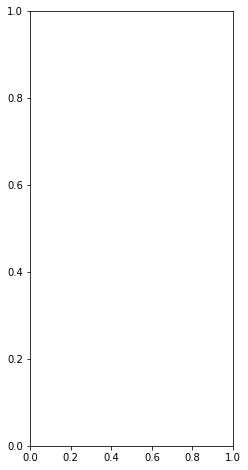

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

